# Glacier Meltwater Runoff model
This notebook walks through modelling how meltwater will flow over a glacier and how it will change with different kinds of meltwater production. This was a Team Project created for CSDMS - Earth Surface Processes Institute (ESPIn) Workshop 2023.

#### Team Members
Emily Glazer (Columbia University)
<br />
Jonas Eschenfelder (Simon Fraser University)
<br />
David Carchipulla-Morales (Wake Forest University)
<br />
Mikayla Pascual (University of Texas at Austin)
<br />
Naureen Khan (State University of New York at Buffalo)

### Study Motivation
Glacier Surface Hydrology is the key role to understand and study the meltwater dynamics of when and how water flows across glaciers and ice sheets. This lab notebook is desgined for undergraduates and graduate students to learn how meltwater flows across different types of glaciers in the world.

### Overview
This lab begins with exploring a Parabolic Synthetic Glacier, Channelized Synthetic Glacier, Nye-Dome Based Synthetic Glacier, Northern Andes Mountain Glaciers using Digital Elevation Model (DEM) Dataset and an optional glacier case with the user inputted DEM coordinates to explore other glaciers of the world. 

### Learning Objectives
- Importing Python Packages and Landlab Components
- Create a Python Class with various methods
- Create Python Functions within Python Class
- Importing DEM Topography
- Create Topography Grids
- Calling Class functions to explore different cases
- Visualizing Exercies using matplotlib package

## Importing Relevant Packages

In [1]:
from landlab.components import FlowDirectorD8, FlowAccumulator, SinkFillerBarnes
from landlab import RasterModelGrid
from landlab.plot.drainage_plot import drainage_plot
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

## Create Class for DEM and FlowAccumulator

In [93]:
class GlacierSurfaceFlow:
    '''
    Class to create model grid and FlowAccumulator for a glacier. Sets a grid for a given test case, creates a FlowAccumulator using the FlowDirectorD8 and contains 
    graphing functions to visualise the data.
    '''
    
    
    def __init__(self,case):        
        if case == 'Parabola':
            self.case = case
            self.grid = RasterModelGrid((10,10)) #create model grid
            self.elev = self.grid.add_field("topographic__elevation", self.grid.y_of_node+ 0.1 * (self.grid.x_of_node-4)**2, at="node") #add sloping parabola as elevation
        
        if case == 'Channel':
            self.case = case
            self.grid = RasterModelGrid((10,10)) #create model grid
            self.elev = self.grid.add_field("topographic__elevation", 1*self.grid.y_of_node, at="node") 
            self.elev[(self.grid.x_of_node > 2) & (self.grid.x_of_node < 4)] -=2 #add channel to topography
            
        if case == 'Nye Dome':
            self.case = case
            self.grid = RasterModelGrid((100,100)) #create model grid
            
            # calculate 
            z2 = 700 - 0.5*((self.grid.y_of_node-50)**2 + (self.grid.x_of_node-50)**2)
            z2[z2 <0]=0.1*np.random.rand(len(z2[z2<0]))
            elev = self.grid.add_field('topographic__elevation',np.sqrt(z2),at='node')
        
    def create_flow_acc(self,flow_director='FlowDirectorD8',runoff_rate=None):
        self.fa = FlowAccumulator(self.grid,flow_director=flow_director,runoff_rate = runoff_rate)
        self.fa.run_one_step()
        self.da,self.q = self.fa.accumulate_flow()
    
    def surf_plot(self,surface='topographic__elevation', title=None):
        if title == None:
            title = f'Topography for {self.case}'
        plt.figure()
        ax=plt.axes(projection='3d')

        # plot the surface
        z = self.grid.at_node[surface].reshape(self.grid.shape)
        ax.plot_surface(
            self.grid.x_of_node.reshape(self.grid.shape),
            self.grid.y_of_node.reshape(self.grid.shape),
            z,
            rstride=1,
            cstride=1,
            cmap=cm.gray,
            linewidth=0.0,
            antialiased=False,
        )
        ax.view_init(elev=35,azim=-120)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('elevation')
        plt.title(title)
        plt.show()

## Plot synthetic glacier surfaces

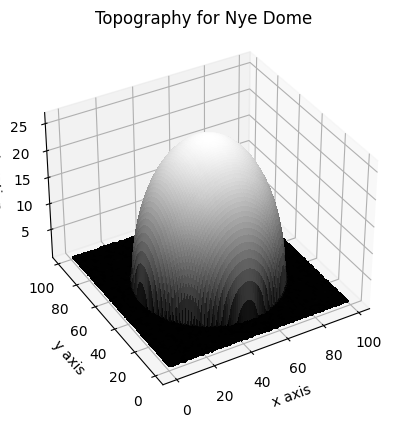

In [3]:
NyeDome = GlacierSurfaceFlow('Nye Dome')
NyeDome.surf_plot()

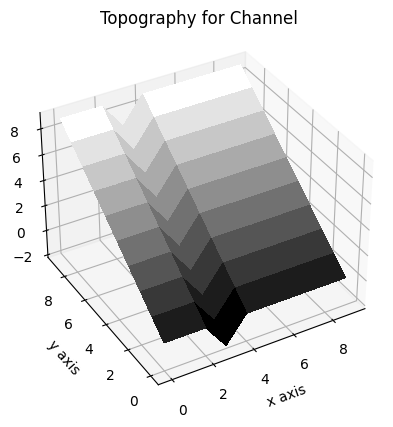

In [25]:
channel = GlacierSurfaceFlow('Channel')
channel.surf_plot()

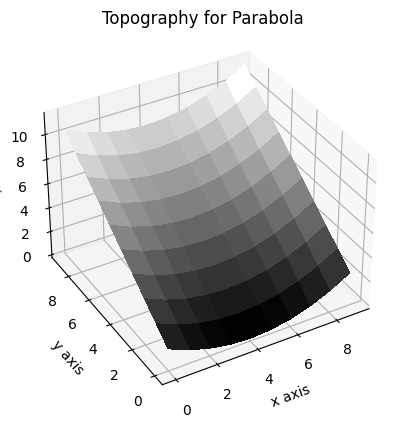

In [5]:
parabola = GlacierSurfaceFlow('Parabola')
parabola.surf_plot()

## Running flow accumulator on channel synthetic glacier

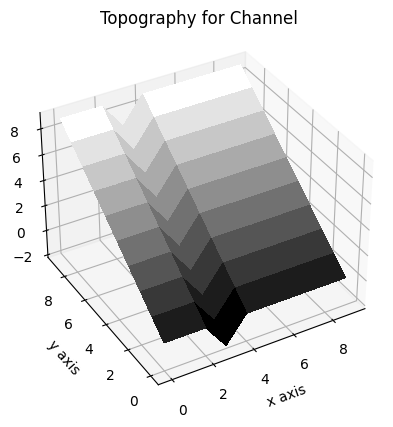

In [94]:
channel = GlacierSurfaceFlow('Channel')
channel.create_flow_acc()
channel.surf_plot()

In [95]:
runoff_rate = np.ones_like(channel.grid.at_node['water__unit_flux_in']) * 10
runoff_rate[(channel.grid.y_of_node==7) & (channel.grid.x_of_node==7)] = 100
channel.grid.at_node['water__unit_flux_in'] = runoff_rate

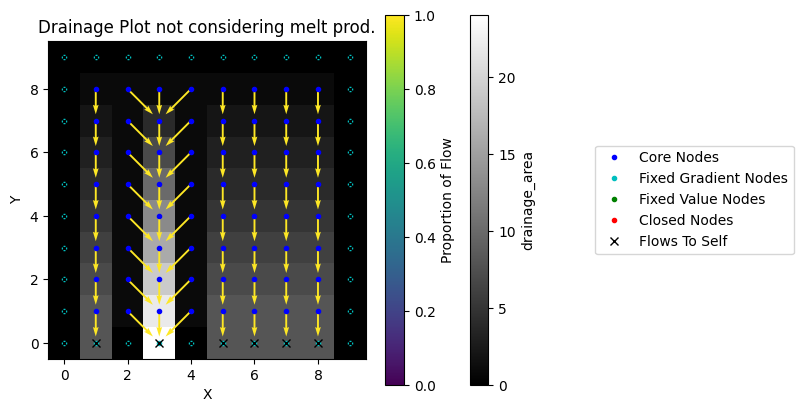

In [96]:
drainage_plot(channel.grid,surface='drainage_area', title='Drainage Plot not considering melt prod.')
plt.show()

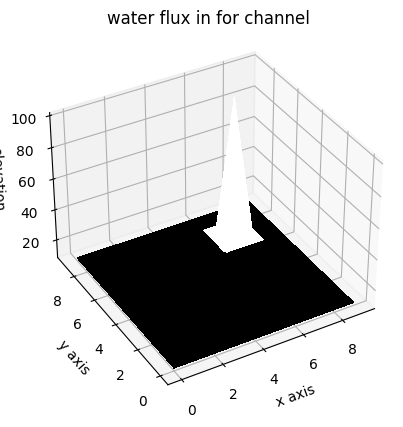

In [97]:
#channel.grid.at_node.keys()
channel.surf_plot(surface='water__unit_flux_in',title='water flux in for channel')

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


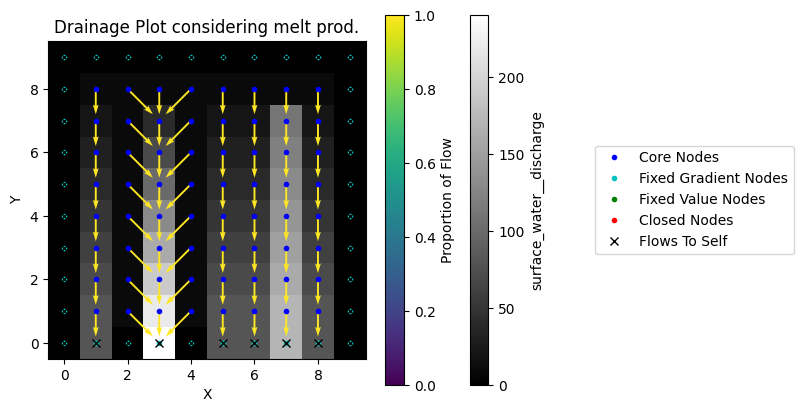

In [98]:
channel.create_flow_acc(runoff_rate = runoff_rate)
drainage_plot(channel.grid,surface='surface_water__discharge',title='Drainage Plot considering melt prod.')
plt.show()